# Sticking to the Target

### 1. Import Libraries

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
import time
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from maddpg import MADDPG

### 2. Create the Unity Environment

Using the Tennis environment, a unity agents 'brain' is created, which is responsible for deciding the agents actions. 

In [2]:
# Set environment and display information
env = UnityEnvironment(file_name='Tennis.app')

# Set the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 3. Train the Agent

#### Training Implementation
An `maddpg_training` function is used for implementating the training for both agents and stores the best weights of the model once an average score, over 100 episodes, of 0.5 or more has been achieved across the 2 agents.

This algorithm consists of a Multi-Agent Deep Deterministic Policy Gradient (MADDPG) with the Ornstein-Uhlenbeck process, to create noise within the network and uses an Experience Replay to store a combined collection of the agents experiences.

#### DDPG Architecture
- An _actor_ consisting of a fully-connected network (4 layers):
    - An input layer with 24 inputs, representing the state size
    - 2 hidden layers, one with 256 hidden nodes and another with 128 hidden nodes that are passed through relu activation functions
    - An output layer with 2 outputs, for the number of actions, passed through a tanh activation function


- A _critic_ consisting of a fully-connected network (4 layers):
    - An input layer with 24 inputs, representing the state size
    - 2 hidden layers, one with 260 hidden nodes (256 + actions) and the other with 128 hidden nodes that are passed through relu activation functions
    - An output layer with 1 output, specifying the Q-value

#### Hyperparameters Used
- `BUFFER_SIZE = int(1e6)`: replay buffer size
- `BATCH_SIZE = 128`: minibatch size
- `GAMMA = 0.99`: discount factor
- `TAU = 1e-3`: used for soft update of target parameters
- `UPDATE_EVERY = 2`: num timesteps before each update
- `NUM_UPDATE = 10`: num of updates after set num of timesteps
- `NOISE_DECAY = 0.995`: reduce exploration slowly overtime
- `LR_ACTOR = 1e-3`: learning rate of the actor
- `LR_CRITIC = 1e-3`: learning rate of the critic

In [3]:
def maddpg_training(brain_name, n_agents, n_episodes=2000, 
                  max_t=1000, print_every=100):
    """
    Perform MADDPG training on both agents.
    
    Parameters:
      - brain_name (string): name of agent brain to use
      - n_agents (list): number of agents
      - n_episodes (int): maximum number of training episodes
      - max_t (int): maximum number of timesteps per episode
      - print_every (int): number of scores to average
    """
    scores_list = []  # list containing scores from each episode
    scores_window = deque(maxlen=print_every) # last set of scores
    scores_avg = []
    
    # Iterate over each episode
    for i_episode in range(1, n_episodes+1):
        # Reset environment and agents, set initial states
        # and reward scores every episode
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(n_agents)
        maddpg.reset_agents()
        
        # Iterate over each timestep
        for t in range(max_t):
            # Perform an action for each agent
            actions = maddpg.act(states)
            
            # Step through the environment using the actions
            env_info = env.step(actions)[brain_name]
            
            # Set new experiences and interact with the environment
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            maddpg.step(states, actions, rewards, next_states, dones, t)
            
            # Update states and scores
            states = next_states
            scores += rewards
            
            # Break loop if an agent finishes the episode
            if any(dones):
                break 
        
        # Save most recent scores
        scores_window.append(np.max(scores))
        scores_list.append(np.max(scores))
        scores_avg.append(np.mean(scores_window))
        
        # Output episode information
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % print_every == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        
        # Save environment if goal achieved
        if np.mean(scores_window) >= 0.5:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            maddpg.save_model()
            break
            
    # Return reward scores
    return scores_list, scores_avg

In [4]:
# Initialize the environment
env_info = env.reset(train_mode=True)[brain_name]

# Set number of actions
action_size = brain.vector_action_space_size # 2

# Set states for each agent
states = env_info.vector_observations
state_size = states.shape[1] # 24

# Create agents
maddpg = MADDPG(state_size, action_size, seed=1, n_agents=2)

In [5]:
# Start training time
start_time = time.time()

# Train both agents
train_scores, avg_train_scores = maddpg_training(brain_name, n_agents=2)

# Calculate time taken to train
train_time = (time.time() - start_time) / 60
print(f"\nTotal Training Time: {train_time:.2f} mins")

Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.07
Episode 300	Average Score: 0.12
Episode 400	Average Score: 0.14
Episode 442	Average Score: 0.51
Environment solved in 442 episodes!	Average Score: 0.51

Total Training Time: 64.67 mins


### 4. Analyse the Training Results

Reviewing the graph we can see the score slowly increase over each episode, where the highest average score across both agents is 0.51 and the environment was solved in 442 episodes, across 100 consecutive episodes with the average of both agents scores. 

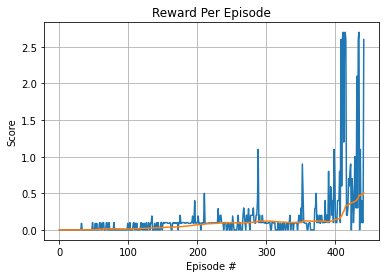

In [6]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(train_scores)), train_scores)
plt.plot(np.arange(len(train_scores)), avg_train_scores)
plt.title('Reward Per Episode')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid(True)
plt.show()

### 5. Test the Trained Agents
Now that the agents have been trained, the environment can be reset and set into test mode using the `train_mode=False` flag. Using the the best weights for the agents we can run the Unity environment to test the agents.

In [11]:
# Initialize environment
env_info = env.reset(train_mode=False)[brain_name]

# Set number of actions and agents
action_size = brain.vector_action_space_size # 2
num_agents = len(env_info.agents) # 2

# Set states for each agent
states = env_info.vector_observations
state_size = states.shape[1] # 24

# Create the agent
test_maddpg = MADDPG(state_size, action_size, seed=1, n_agents=num_agents)
test_scores = np.zeros(num_agents)

# Set best device available
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

# Load best agent weights
test_maddpg.load_model(map_location)

In [12]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = maddpg.act(states)                        # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (max over agents) this episode: {}'.format(np.max(scores)))

Total score (max over agents) this episode: 0.5000000074505806


### 6. Close the Environment
When finished, we close the environment.

In [13]:
env.close()